In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import skutils
import copy
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score, brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from IPython.core.pylabtools import figsize

seed = 47
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read data

big = pd.read_csv('train.csv')

In [3]:
# 2.2.2 Target variable

big.species = big.species.astype('category')
big.species = big.species.cat.codes

def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [4]:
# 2.2.3 Additional preprocessing

def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [5]:
# Train and plot functions

def train(classifiers, size):
    sss = StratifiedShuffleSplit(10, test_size=size, random_state=seed)
    clfs = copy.deepcopy(classifiers)
    
    for clf in clfs.keys(): 
        c = clfs[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        for clf in clfs.keys():                    
            c = clfs[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = np.asarray(c["f"].predict(X_test))

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc' and meas != 'br'):
                    c[meas].append(m(y_test, y_pred, average='macro'))
                elif (meas == 'll'):
                    c[meas].append(m(y_test, y_pred, labels=y_test))
                else:
                    c[meas].append(m(y_test, y_pred))
    
    return clfs

def plot_param(cl, classifier, post):
    results = pd.DataFrame(columns=measures)

    for model in cl.keys():
        if (model.startswith(classifier)):
            res = [np.mean(cl[model][measure]) for measure in measures.keys()]
            results.loc[model] = res

    results = results.sort_index()
    
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.title(classifier)

    plt.savefig("plots/" + classifier + "_compare_" + post + ".png")
    plt.show()
    
def plot_param_2(classifiers, cl):
    for model in classifiers.keys():
        results = pd.DataFrame(columns=measures)

        for i in range(0,len(cl)):
            res = [np.mean(cl[i][model][measure]) for measure in measures.keys()]
            results.loc[sizes[i]] = res

        figsize(10, 5)
        ax = plt.subplot(111)

        ind = np.arange(results.shape[0])
        width = 0.2
        l = ax.plot(ind, results, "-o")
        plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlim([-0.25, ind[-1]+.25])
        ax.set_xticks(ind)
        ax.set_xticklabels(results.index)
        plt.title(model)

        plt.savefig("plots/" + model + "_split.png")
        plt.show()
        

In [6]:
# 3.1 Quality metrics

measures = {
    'pre': precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score,
}

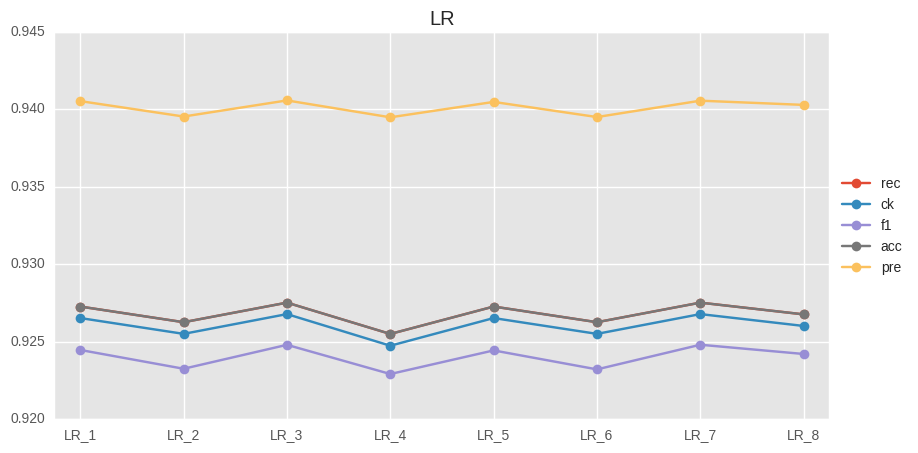

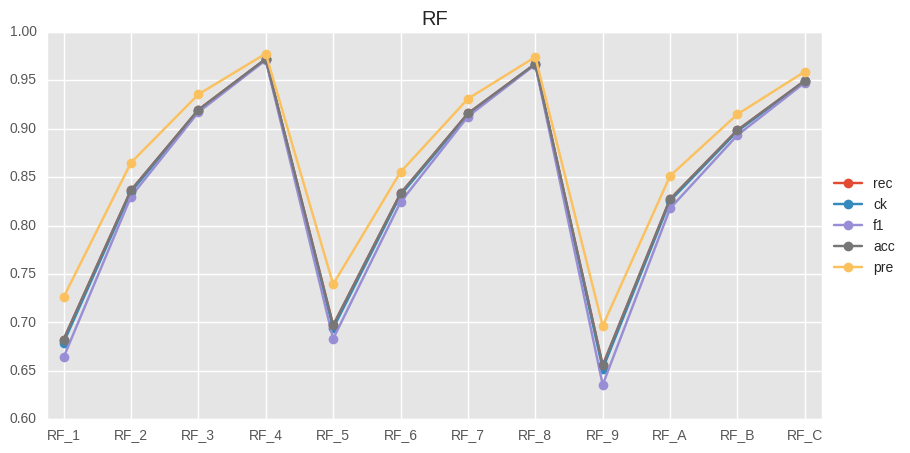

In [7]:
# 3.2 Parameters

classifiers_test_param = {
        "LR_1": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=1, penalty='l2') },
        "LR_2": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=0.8, penalty='l2') },
        "LR_3": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=1.2, penalty='l2') },
        "LR_4": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=10, penalty='l2') },
        "LR_5": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=1, penalty='l2') },
        "LR_6": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=0.8, penalty='l2') },
        "LR_7": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=1.2, penalty='l2') },
        "LR_8": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=10, penalty='l2') },
        "RF_1": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_2": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_3": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_4": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_5": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_6": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_7": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_8": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_9": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_A": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_B": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_C": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
}

cl_test_param = train(classifiers_test_param, 0.4)
    
plot_param(cl_test_param, "LR", "param")
plot_param(cl_test_param,"RF", "param")

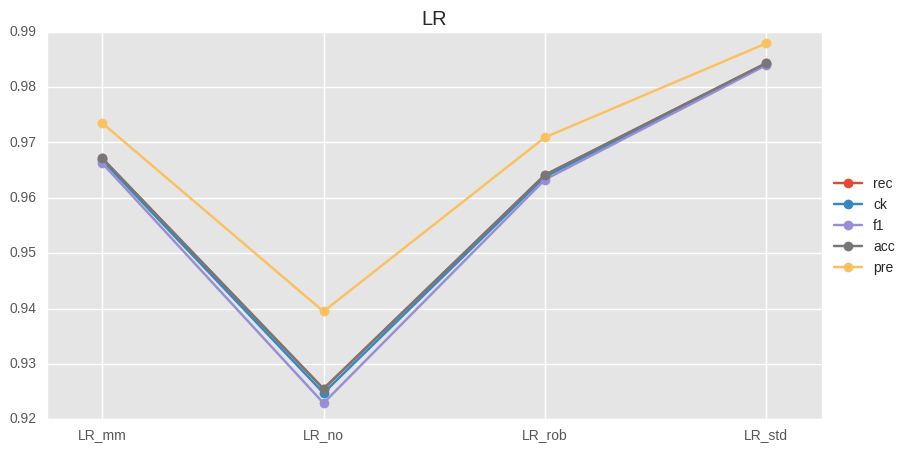

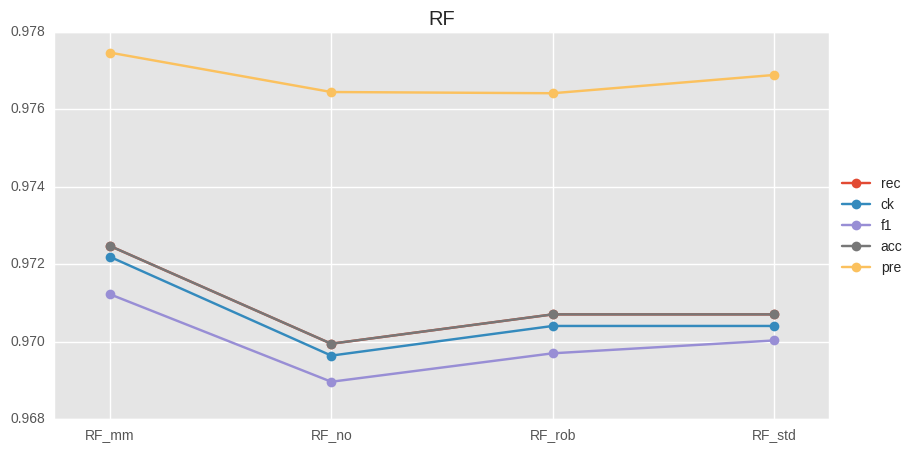

In [8]:
# 3.3 Scaling

classifiers_test_scaling = {
    "LR_no": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1) },
    "RF_no": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
    "LR_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1))
            ]) },
    "LR_mm": { "f": Pipeline([
                ('scaling', MinMaxScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1))
            ]) },
    "LR_rob": { "f": Pipeline([
                ('scaling', RobustScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1))
            ]) },
    "RF_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, n_jobs=-1))
            ]) },
    "RF_mm": { "f": Pipeline([
                ('scaling', MinMaxScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, n_jobs=-1))
            ]) },
    "RF_rob": { "f": Pipeline([
                ('scaling', RobustScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, n_jobs=-1))
            ]) },
}    

cl_test_param = train(classifiers_test_scaling, 0.4)

plot_param(cl_test_param, "LR", "scaling")
plot_param(cl_test_param,"RF", "scaling")

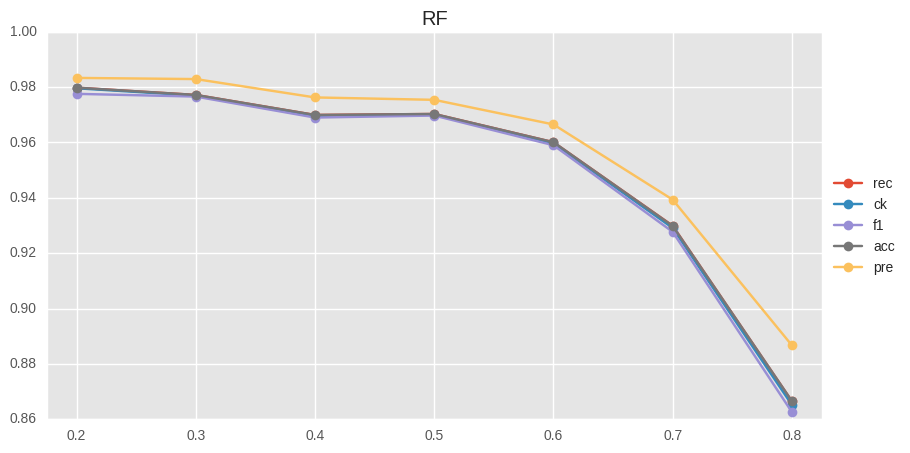

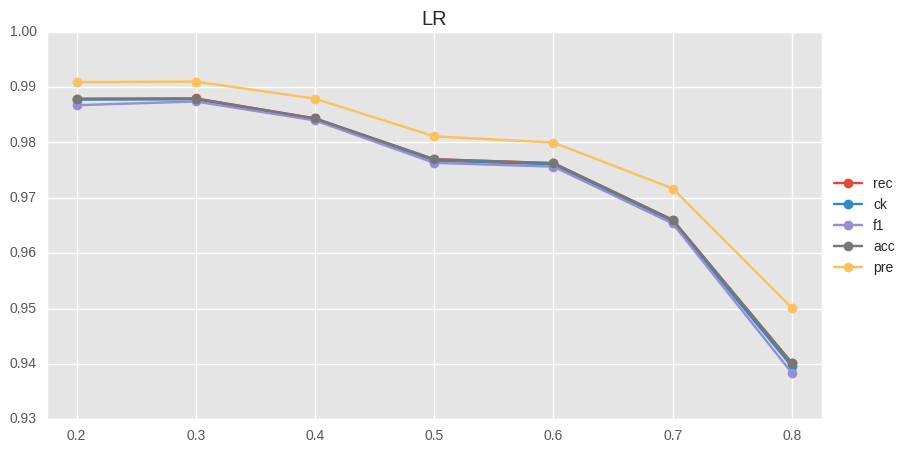

In [9]:
# 3.4 Training / test split

classifiers_final = {
    "LR": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=10, n_jobs=-1))
            ]) },
    "RF": { "f": Pipeline([
                ('scaling', MinMaxScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, n_jobs=-1))
            ]) },
}

sizes = []
for i in range(1,8):
    sizes.append(0.1 + 0.1 * i)

cl_test_split_size = []    
for s in sizes:
    cl_test_split_size.append(train(classifiers_final, s))

plot_param_2(classifiers_final, cl_test_split_size)